In [0]:
!pip install xgboost

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-ad8032f6-76ff-4884-ba60-b0bd3b9097b4/bin/python -m pip install --upgrade pip' command.


In [0]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from IPython.display import display

from typing import List, Tuple
from functools import cache  # Python 3.9 required

import yfinance as yf
import datetime
pd.options.display.float_format = "{:,.5f}".format


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import random

In [0]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 9

In [0]:
TREASURY_BILL_RATE = 3.29  #%, Jan 2021
TRADING_DAYS_PER_YEAR = 250

In [0]:
# Needed for type hinting
class Asset:
  pass


def get_log_period_returns(price_history: pd.DataFrame):
  close = price_history['Close'].values  
  return np.log(close[1:] / close[:-1]).reshape(-1, 1)


# daily_price_history has to at least have a column, called 'Close'
class Asset:
  def __init__(self, name: str, daily_price_history: pd.DataFrame):
    self.name = name
    self.daily_returns = get_log_period_returns(daily_price_history)
    self.expected_daily_return = np.mean(self.daily_returns)
  
  @property
  def expected_return(self):
    return TRADING_DAYS_PER_YEAR * self.expected_daily_return

  def __repr__(self):
    return f'<Asset name={self.name}, expected return={self.expected_return}>'

  @staticmethod
  @cache
  def covariance_matrix(assets: Tuple[Asset]):  # tuple for hashing in the cache
    product_expectation = np.zeros((len(assets), len(assets)))
    for i in range(len(assets)):
      for j in range(len(assets)):
        if i == j:
          product_expectation[i][j] = np.mean(assets[i].daily_returns * assets[j].daily_returns)
        else:
          product_expectation[i][j] = np.mean(assets[i].daily_returns @ assets[j].daily_returns.T)
    
    product_expectation *= (TRADING_DAYS_PER_YEAR - 1) ** 2

    expected_returns = np.array([asset.expected_return for asset in assets]).reshape(-1, 1)
    product_of_expectations = expected_returns @ expected_returns.T

    return product_expectation - product_of_expectations


def random_weights(weight_count):
    weights = np.random.random((weight_count, 1))
    weights /= np.sum(weights)
    return weights.reshape(-1, 1)


class Portfolio:
  def __init__(self, assets: Tuple[Asset]):
    self.assets = assets
    self.asset_expected_returns = np.array([asset.expected_return for asset in assets]).reshape(-1, 1)
    self.covariance_matrix = Asset.covariance_matrix(assets)
    self.weights = random_weights(len(assets))
    
  def unsafe_optimize_with_risk_tolerance(self, risk_tolerance: float):
    res = minimize(
      lambda w: self._variance(w) - risk_tolerance * self._expected_return(w),
      random_weights(self.weights.size),
      constraints=[
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
      ],
      bounds=[(0., 1.) for i in range(self.weights.size)]
    )

    assert res.success, f'Optimization failed: {res.message}'
    self.weights = res.x.reshape(-1, 1)
  
  def optimize_with_risk_tolerance(self, risk_tolerance: float):
    assert risk_tolerance >= 0.
    return self.unsafe_optimize_with_risk_tolerance(risk_tolerance)
  
  def optimize_with_expected_return(self, expected_portfolio_return: float):
    res = minimize(
      lambda w: self._variance(w),
      random_weights(self.weights.size),
      constraints=[
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
        {'type': 'eq', 'fun': lambda w: self._expected_return(w) - expected_portfolio_return},
      ],
      bounds=[(0., 1.) for i in range(self.weights.size)]
    )

    assert res.success, f'Optimization failed: {res.message}'
    self.weights = res.x.reshape(-1, 1)

  def optimize_sharpe_ratio(self):
    # Maximize Sharpe ratio = minimize minus Sharpe ratio
    res = minimize(
      lambda w: -(self._expected_return(w) - TREASURY_BILL_RATE / 100) / np.sqrt(self._variance(w)),
      random_weights(self.weights.size),
      constraints=[
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
      ],
      bounds=[(0., 1.) for i in range(self.weights.size)]
    )

    assert res.success, f'Optimization failed: {res.message}'
    self.weights = res.x.reshape(-1, 1)

  def _expected_return(self, w):
    return (self.asset_expected_returns.T @ w.reshape(-1, 1))[0][0]
  
  def _variance(self, w):
    return (w.reshape(-1, 1).T @ self.covariance_matrix @ w.reshape(-1, 1))[0][0]

  @property
  def expected_return(self):
    return self._expected_return(self.weights)
  
  @property
  def variance(self):
    return self._variance(self.weights)

  def __repr__(self):
    return f'<Portfolio assets={[asset.name for asset in self.assets]}, expected return={self.expected_return}, variance={self.variance}>'


In [0]:
def yf_retrieve_data(tickers: List[str], end_date: str):
  dataframes = []

  for ticker_name in tickers:
    ticker = yf.Ticker(ticker_name)
    history = ticker.history(start = "2017-10-05" , end = end_date)

    if history.isnull().any(axis=1).iloc[0]:  # the first row can have NaNs
      history = history.iloc[1:]
  
    assert not history.isnull().any(axis=None), f'history has NaNs in {ticker_name}'
    dataframes.append(history)
  
  return dataframes

In [0]:
stocks = ['AAPL', 'AMZN', 'CCEP', 'KOF', 'STLA', 'AC.MX']

daily_dataframes = yf_retrieve_data(stocks, str(datetime.date.today()-datetime.timedelta(0)))
assets = tuple([Asset(name, daily_df) for name, daily_df in zip(stocks, daily_dataframes)])

In [0]:
assets

Out[296]: (<Asset name=AAPL, expected return=0.2725037155946156>,
 <Asset name=AMZN, expected return=0.1781774004291396>,
 <Asset name=CCEP, expected return=0.043528796780760125>,
 <Asset name=KOF, expected return=-0.006902259805183508>,
 <Asset name=STLA, expected return=0.004303865239686384>,
 <Asset name=AC.MX, expected return=0.058510725021458654>)

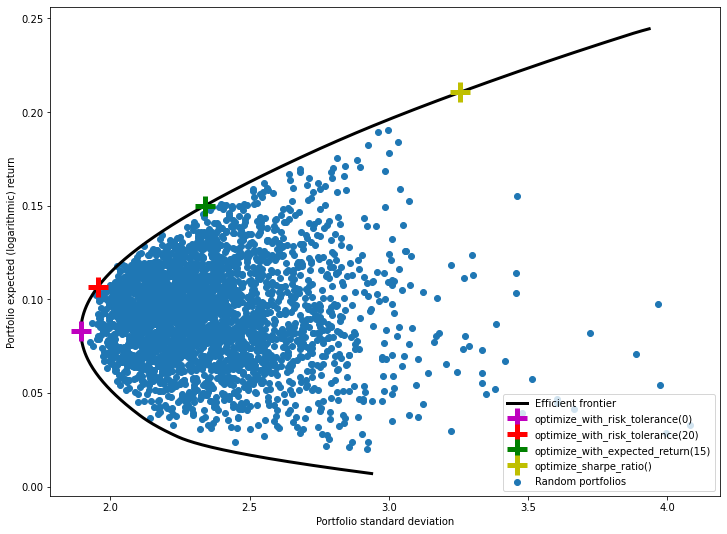

In [0]:
X = []
y = []
Z = []

# Drawing random portfolios
for i in range(3000):
    portfolio = Portfolio(assets)
    X.append(np.sqrt(portfolio.variance))
    y.append(portfolio.expected_return)
    Z.append(portfolio.weights.flatten())

plt.scatter(X, y, label='Random portfolios')

# Drawing the efficient frontier
X = []
y = []
Z = []
for rt in np.linspace(-300, 200, 1000):
    portfolio.unsafe_optimize_with_risk_tolerance(rt)
    X.append(np.sqrt(portfolio.variance))
    y.append(portfolio.expected_return)
    Z.append(portfolio.weights.flatten())  

plt.plot(X, y, 'k', linewidth=3, label='Efficient frontier')

# Drawing optimized portfolios
portfolio.optimize_with_risk_tolerance(0)
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'm+', markeredgewidth=5, markersize=20, label='optimize_with_risk_tolerance(0)')

portfolio.optimize_with_risk_tolerance(20)
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'r+', markeredgewidth=5, markersize=20, label='optimize_with_risk_tolerance(20)')

portfolio.optimize_with_expected_return(0.15)
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'g+', markeredgewidth=5, markersize=20, label='optimize_with_expected_return(15)')

portfolio.optimize_sharpe_ratio()
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'y+', markeredgewidth=5, markersize=20, label='optimize_sharpe_ratio()')

plt.xlabel('Portfolio standard deviation')
plt.ylabel('Portfolio expected (logarithmic) return')
plt.legend(loc='lower right')
plt.show()

In [0]:
portfolio = Portfolio(assets)
portfolio.optimize_with_risk_tolerance(0)
riskless_weights = portfolio.weights.flatten()

portfolio.optimize_with_risk_tolerance(20)
weights_risk_tolerance = portfolio.weights.flatten()

portfolio.optimize_with_expected_return(0.15)
weights_return = portfolio.weights.flatten()

portfolio.optimize_sharpe_ratio()
weights_sharpe = portfolio.weights.flatten()

display(
  pd.DataFrame(
    list(
      zip(
        [asset.name for asset in portfolio.assets],
        riskless_weights,
        weights_risk_tolerance,
        weights_return,
        weights_sharpe,
      )
    ),
    columns=[
      'asset',
      'optimize_with_risk_tolerance(0)',
      'optimize_with_risk_tolerance(20)',
      'optimize_with_expected_return(0.15)',
      'optimize_sharpe_ratio()',
    ],
  )
)

af = pd.DataFrame(
    list(
      zip(
        [asset.name for asset in portfolio.assets],
        riskless_weights,
        weights_risk_tolerance,
        weights_return,
        weights_sharpe,
      )
    ),
    columns=[
      'asset',
      'optimize_with_risk_tolerance(0)',
      'optimize_with_risk_tolerance(20)',
      'optimize_with_expected_return(0.15)',
      'optimize_sharpe_ratio()',
    ],
  )

,asset,optimize_with_risk_tolerance(0),optimize_with_risk_tolerance(20),optimize_with_expected_return(0.15),optimize_sharpe_ratio()
0,AAPL,0.13756,0.21028,0.34217,0.54887
1,AMZN,0.12084,0.15294,0.21116,0.29106
2,CCEP,0.14316,0.12744,0.09893,0.02593
3,KOF,0.19754,0.14810,0.05836,0.00000
4,STLA,0.08187,0.06393,0.03138,0.00000
5,AC.MX,0.31903,0.29730,0.25800,0.13415


In [0]:
betas = {"AAPL":1.25, "AMZN":1.33,"CCEP":0.7,"KOF":0.77,"STLA":2.65,"AC.MX":0.24}
be = []
for x in [x for x in af.columns if x != "asset"]:
    suma = 0
    for a,b in zip(betas.values(), list(af[x])):
        suma += a*b
    be.append(suma)
be.insert(0,"BETAS")

In [0]:
final = pd.concat([af,pd.DataFrame(dict(zip(af.columns,[[x] for x in be])))])
final

,asset,optimize_with_risk_tolerance(0),optimize_with_risk_tolerance(20),optimize_with_expected_return(0.15),optimize_sharpe_ratio()
0,AAPL,0.13574,0.20654,0.32623,0.50391
1,AMZN,0.11918,0.14966,0.20115,0.26803
2,CK0.SG,0.15485,0.15057,0.14341,0.10383
3,KOF,0.19485,0.14277,0.05478,0.00000
4,STLA,0.08077,0.06172,0.02956,0.00000
5,AC.MX,0.31462,0.28873,0.24487,0.12423
0,BETAS,0.87615,0.90543,0.95499,1.08887


# Model

In [0]:
def simulaciones_riesgo(x):
    portfolio.optimize_with_risk_tolerance(x)
    risk = x
    d_sd = np.sqrt(portfolio.variance)
    expected_return = portfolio.expected_return
    weights = portfolio.weights.flatten()
    
    return pd.DataFrame({"Risk_tolerance":[risk], "Standard_Deviation":[d_sd], "Expected_return":[expected_return], "weights": [weights]})

In [0]:
resultados = pd.DataFrame()
for x in range(300):
    resultados = pd.concat([resultados, simulaciones_riesgo(x)])

In [0]:
def simulacion_dias(n=0):
    stocks = ['AAPL', 'AMZN', 'CCEP', 'KOF', 'STLA', 'AC.MX']

    daily_dataframes = yf_retrieve_data(stocks, str(datetime.date.today()-datetime.timedelta(n)))
    assets = tuple([Asset(name, daily_df) for name, daily_df in zip(stocks, daily_dataframes)])
    
    X = []
    y = []
    Z = []

    # Drawing random portfolios
    for i in range(3000):
        portfolio = Portfolio(assets)
        X.append(np.sqrt(portfolio.variance))
        y.append(portfolio.expected_return)
        Z.append(portfolio.weights.flatten())


    # Drawing the efficient frontier
    X = []
    y = []
    Z = []
    for rt in np.linspace(-300, 200, 1000):
        portfolio.unsafe_optimize_with_risk_tolerance(rt)
        X.append(np.sqrt(portfolio.variance))
        y.append(portfolio.expected_return)
        Z.append(portfolio.weights.flatten())  
        
    resultados = pd.DataFrame()
    for x in range(100):
        resultados = pd.concat([resultados, simulaciones_riesgo(x)])
    resultados["date"]=str(datetime.date.today()-datetime.timedelta(n))
        
    return resultados

In [0]:
simulaciones = pd.DataFrame()
for x in [random.randint(0,730) for x in range(160)]:
    simulaciones = pd.concat([simulaciones, simulacion_dias(x)])
    

simulaciones = simulaciones.reset_index(drop=True)

In [0]:
dataset = simulaciones.reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(dataset["Risk_tolerance"], dataset["Expected_return"])

In [0]:
# define model
model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = abs(scores)
print('Mean MAPE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAPE: 0.001 (0.000)


In [0]:
model.fit(X_train, y_train)

model.score(X_test, y_test)

Out[291]: 0.9999773958502685

In [0]:
model.predict(np.array([20]))[0]

Out[292]: 0.11095945

In [0]:
dataset

,Risk_tolerance,Standard_Deviation,Expected_return,weights,date
0,0,1.88123,0.08770,"[0.13570424512355114, 0.1191808724130364, 0.15...",2022-02-02
1,1,1.88138,0.08886,"[0.13921202715608685, 0.12071187110015737, 0.1...",2022-02-02
2,2,1.88184,0.09002,"[0.14277638818033506, 0.12224116513994963, 0.1...",2022-02-02
3,3,1.88261,0.09118,"[0.14631557371036202, 0.1237669266551663, 0.15...",2022-02-02
4,4,1.88369,0.09234,"[0.1498941817368908, 0.12528261842338953, 0.15...",2022-02-02
...,...,...,...,...,...
15995,95,2.84329,0.18979,"[0.46057847820775666, 0.2536984863280155, 0.12...",2022-06-25
15996,96,2.85522,0.19051,"[0.4634655327565513, 0.2546416175532945, 0.120...",2022-06-25
15997,97,2.86733,0.19122,"[0.4663758066918869, 0.2555982553282222, 0.119...",2022-06-25
15998,98,2.87910,0.19192,"[0.46919894232352893, 0.25650329905646196, 0.1...",2022-06-25


In [0]:
dataset[dataset["Risk_tolerance"]==8].display()

Risk_tolerance,Standard_Deviation,Expected_return,weights,date
8,1.891056373307275,0.09697195357418256,"List(0.16402011750580467, 0.1314307970200345, 0.15314182187373424, 0.1740511016287629, 0.07311124078293305, 0.3042449211887306)",2022-02-02
8,1.89104857933642,0.09696826219420265,"List(0.16402881651320067, 0.1313771769429881, 0.15319818982407082, 0.17405463233207186, 0.0731113000414387, 0.30422988434622994)",2021-01-02
8,1.8910421918125675,0.09696525026742814,"List(0.1640232297598865, 0.13139826545024083, 0.15314312513817305, 0.1740736950661508, 0.07314857629323418, 0.3042131082923146)",2021-01-26
8,1.8910402087770153,0.09696432851188781,"List(0.16401231495541235, 0.13138011546718342, 0.1531226516023943, 0.1740160862213679, 0.0731445869192519, 0.3043242448343901)",2021-02-23
8,1.8910555860283382,0.0969715777494547,"List(0.16406313556563717, 0.13138515677338838, 0.15308729497558907, 0.17408542172543548, 0.07312623618565517, 0.3042527547742947)",2021-03-03
8,1.891017158084744,0.09695341243154094,"List(0.1639722889832693, 0.13138758896676297, 0.1531530835020723, 0.17405554675599194, 0.07316776803051785, 0.30426372376138544)",2022-01-06
8,1.8910535824791435,0.09697065081438122,"List(0.16403742694221066, 0.1313771767362404, 0.1531493290468475, 0.17402278160485093, 0.07312210659274673, 0.3042911790771038)",2022-06-13
8,1.8910461948174127,0.09696715861947737,"List(0.16402740144578298, 0.13137489342986367, 0.15311802354609202, 0.174008085160976, 0.07314839884256104, 0.30432319757472426)",2021-11-08
8,1.891049173470457,0.09696856934763214,"List(0.16402880261852812, 0.13138377220689146, 0.15313221328145096, 0.17401761031271878, 0.07314110992583756, 0.30429649165457306)",2021-05-01
8,1.8910450393500169,0.09696660432638501,"List(0.16401825990755142, 0.13136843551921037, 0.1531246363852821, 0.17398783770459936, 0.07313508881943367, 0.30436574166392305)",2021-12-25
